In [1]:
import pandas as pd
import glob
import os 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from Bio import SeqIO
import tarfile
import gzip
%load_ext autoreload
%autoreload 2
from helpers_barplot_intersection import plot_intersection_bars, plotting_parameters, sort_filters, calculate_mean_std



Matplotlib created a temporary config/cache directory at /scratch/slurm-job.4413966/matplotlib-kc2b2f9_ because the default path (/cluster/customapps/biomed/grlab/users/prelotla/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
np.arange(0, 10, 2)

array([0, 2, 4, 6, 8])

In [3]:
class MS_parameters():
    def __init__(self, FDR_limit):
        self.FDR_limit = FDR_limit
    def edit_pep_type(self, pep_type):
        self.pep_type = pep_type
    def edit_MS(self, MS_FDR, MS_strategy):
        self.MS_FDR = MS_FDR
        self.MS_strategy = MS_strategy
        
   

In [4]:
# INPUTS 
proteomicsdir = '/cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024'
#proteomicsdir = '/cluster/work/grlab/projects/projects2020_OHSU/proteomics'


FDR_limit = 0.05
MS_FDR_ = ['_crema']#, '_crux']
MS_strategy_ = ['joint'] #, 'single'] #pool

#pool: pool all experiments per pipeline
#joint: pool all experiments for both pipeline
#single: per experiment per pipeline

order_background = ['01', '12', '1X', '1A', '32', '3X', '3A']
order_foreground = ['025', '021', '0A5', '0A1', '0AN']

sample_plot_dir = {}
run_type_plot_dir = {}    
all_samples = []

# BRCA
samples = ['TCGA-C8-A12P-01A-11R-A115-07',
                  'TCGA-AO-A0JM-01A-21R-A056-07',
                  'TCGA-BH-A18V-01A-11R-A12D-07',
                  'TCGA-A2-A0D2-01A-21R-A034-07',
                  'TCGA-A2-A0SX-01A-12R-A084-07']
all_samples.extend(samples)
basedir = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102'
filter_dir = os.path.join(basedir, 'filtering_samples', 'filters_19May_order_5ge_wAnnot_GPstar')

for sample in samples:
    sample_plot_dir[sample] = os.path.join(filter_dir, 'plots')
    run_type_plot_dir[sample] = 'BRCA'
    
# OV
samples = ['TCGA-25-1319-01A-01R-1565-13',
                  'TCGA-25-1313-01A-01R-1565-13',
                  'TCGA-61-2008-01A-02R-1568-13',
                  'TCGA-24-1431-01A-01R-1566-13',
                  'TCGA-24-2298-01A-01R-1569-13']
all_samples.extend(samples)
basedir = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374'
filter_dir = os.path.join(basedir, 'filtering_samples', 'filters_19May_order_5ge_wAnnot_GPstar')

for sample in samples:
    sample_plot_dir[sample] = os.path.join(filter_dir, 'plots')
    run_type_plot_dir[sample] = 'OV'

save_folder = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots'

# PLOTTING Parameters 
ticks_fontsize = 12
axislabels_fontsize = 12
legend_fontsize = 12
axes_fontsize = 15
color1 = 'gold'
color2 = 'crimson'
color3 = 'mediumblue'
color4 = 'k'
colorgrid = 'grey'



save = False
sample = None

# Initialize plotting parameters
param_object = plotting_parameters(ticks_fontsize, axislabels_fontsize, legend_fontsize, axes_fontsize)
param_object.add_saving_instructions(save, run_type_plot_dir, sample_plot_dir)
param_object.add_color_options(color1, color2, color3, color4, colorgrid)

param_MS = MS_parameters(FDR_limit)

# Plot: Results per experiment

In [5]:
# Wrapper for plotting function 
def run_sample_plotting_overlap(sample, df, param_MS, param_object):

    # Ordering
    df_plot = sort_filters(df, order_background, order_foreground)
    df_plot = df_plot.loc[df_plot['sample'] == sample]

    #display(df_plot.head(3))
    

    # Plotting labels and ticks
    param_object.add_x_label('GTEX (reads, samples)', 
                             f'{param_object.run_type_plot_dir[sample].upper()} (min, reads, samples)')
    
    param_object.add_ticks(df_plot['filter_background'], df_plot['filter_foreground'] )
    
    
    param_object.add_plotting_data(data_eth=df_plot, 
                                   data_ohsu=df_plot, 
                                   data_both=df_plot, 
                                   serie_index='index', 
                                   serie_intersection='mean_pep_size_intersection',
                                   serie_eth='mean_pep_size_eth', 
                                   serie_ohsu='mean_pep_size_ohsu')
    
    param_object.add_y_label(f'Number of MS-detected {param_MS.pep_type}')
    
    name_file = f'barplot_intersect_{param_MS.pep_type}{param_MS.MS_FDR}_{param_MS.MS_strategy}'
    name_file = name_file.replace(' ', '-')
    if param_object.log_scale:
        name_file += '_log'
    param_object.add_saving_path(param_object.sample_plot_dir[sample], 'MeanSample', name_file)
                                 
    
    param_object.add_labels('Mean intersection size', 'Mean set size Graph Pipeline',
                            'Mean set size Junction Pipeline')
    
    ms = param_MS.MS_FDR.replace('_', '')
    # DEV param_object.add_title(f'{param_MS.pep_type} searched with {ms} in {param_MS.MS_strategy} strategy \n')
    param_object.add_title(None)
    
    # Plotting function
    plot_intersection_bars(param_object)
    return df_plot

In [6]:
# Wrapper for plotting function 

def run_sample_plotting_rates(sample, df, param_MS, param_object ):
    
    # Ordering
    # Ordering
    df_plot = sort_filters(df, order_background, order_foreground)
    df_plot = df_plot.loc[df_plot['sample'] == sample]


    #display(df_plot.head(3))


    # Plotting labels and ticks
    param_object.add_x_label('GTEX (reads, samples)', 
                             f'{param_object.run_type_plot_dir[sample].upper()} (min, reads, samples)')

    back_ticks = df_plot.loc[df_plot['pipeline'] == 'ETH', 'filter_background'] 
    front_ticks = df_plot.loc[df_plot['pipeline'] == 'ETH', 'filter_foreground']
    param_object.add_ticks(back_ticks, front_ticks)
    

    param_object.add_plotting_data(data_both=None, 
                                   data_eth=df_plot.loc[df_plot['pipeline'] == 'ETH'],
                                   data_ohsu=df_plot.loc[df_plot['pipeline'] == 'OHSU'],
                                   serie_index=None,
                                   serie_intersection=None,
                                   serie_eth='mean_validation_rate',
                                   serie_ohsu='mean_validation_rate')
     
    param_object.add_y_label('Validation percent')
    
    name_file = f'barplot_val-rate_{param_MS.pep_type}{param_MS.MS_FDR}_{param_MS.MS_strategy}'
    name_file = name_file.replace(' ', '-')
    if param_object.log_scale:
        name_file += '_log'
    param_object.add_saving_path(param_object.sample_plot_dir[sample], 'MeanSample', name_file)
    
    param_object.add_labels(None, 'Mean validation percent Graph Pipeline',
                            'Mean validation percent Junction Pipeline')
    
    ms = param_MS.MS_FDR.replace('_', '')
    # DEV param_object.add_title(f'{param_MS.pep_type} searched with {ms} in {param_MS.MS_strategy} strategy \n')
    param_object.add_title(None)
    plot_intersection_bars(param_object)


    return df_plot

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers-rates_crema_joint.tsv.gz


,sample,filter_,pipeline,validation_rate
0,TCGA-C8-A12P-01A-11R-A115-07,0211AGA,ETH,0.0
1,TCGA-C8-A12P-01A-11R-A115-07,0211AGA,OHSU,5.1
2,TCGA-C8-A12P-01A-11R-A115-07,0211XGA,ETH,0.0
3,TCGA-C8-A12P-01A-11R-A115-07,0211XGA,OHSU,5.1
4,TCGA-C8-A12P-01A-11R-A115-07,02532GA,ETH,0.0


saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/MeanSample_barplot_val-rate_junction-9-mers_crema_joint.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:247: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


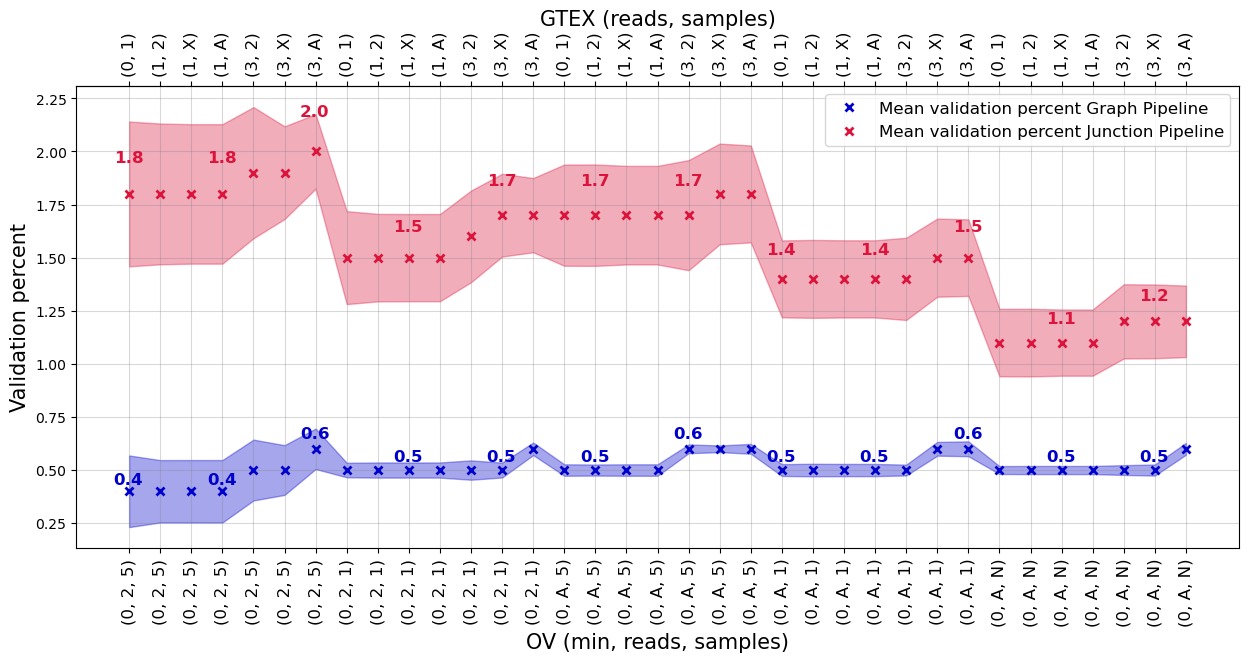

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides-rates_crema_joint.tsv.gz


,sample,filter_,pipeline,validation_rate
0,TCGA-C8-A12P-01A-11R-A115-07,0211AGA,ETH,0.00
1,TCGA-C8-A12P-01A-11R-A115-07,0211AGA,OHSU,5.88
2,TCGA-C8-A12P-01A-11R-A115-07,0211XGA,ETH,0.00
3,TCGA-C8-A12P-01A-11R-A115-07,0211XGA,OHSU,5.88
4,TCGA-C8-A12P-01A-11R-A115-07,02532GA,ETH,0.00


saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/MeanSample_barplot_val-rate_tryptic-junction-peptides_crema_joint.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:247: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


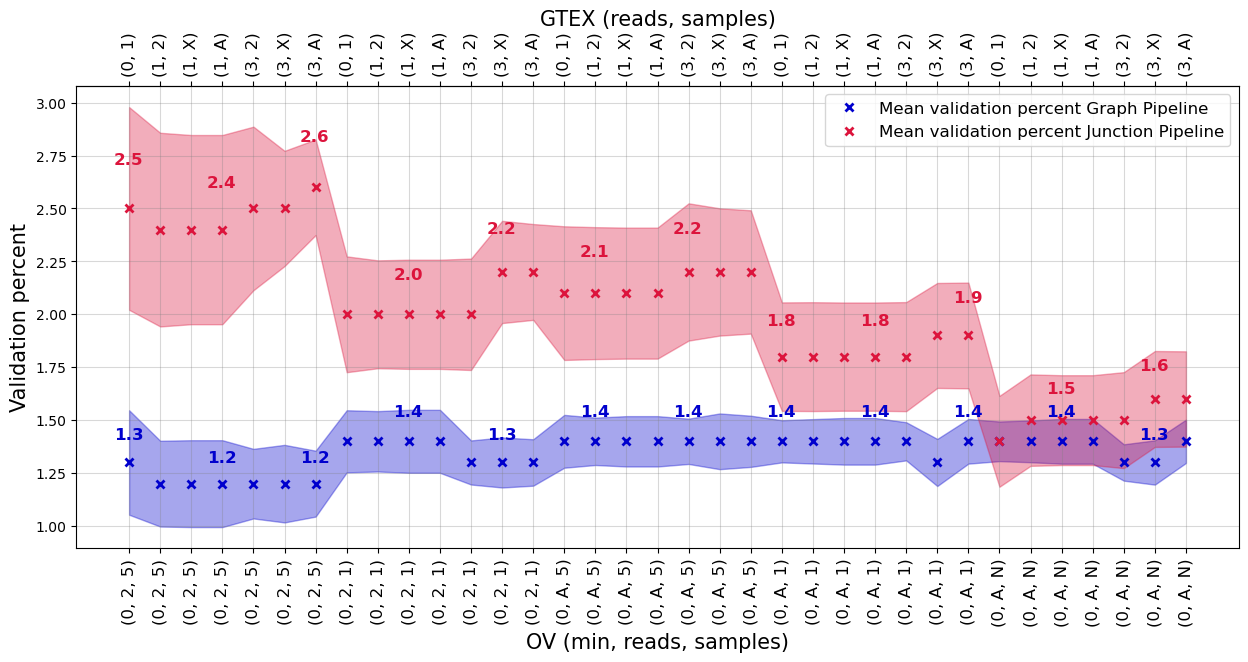

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers_crema_joint.tsv.gz


,sample,filter_,pep_size_ohsu,pep_size_eth,pep_size_intersection,pep_size_ohsu\eth,pep_size_eth\ohsu
0,TCGA-C8-A12P-01A-11R-A115-07,0211AGA,8,0,0,8,0
1,TCGA-C8-A12P-01A-11R-A115-07,0211XGA,8,0,0,8,0
2,TCGA-C8-A12P-01A-11R-A115-07,02532GA,0,0,0,0,0
3,TCGA-C8-A12P-01A-11R-A115-07,0A101GA,8,0,0,8,0
4,TCGA-C8-A12P-01A-11R-A115-07,0A512GA,0,0,0,0,0


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:247: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/MeanSample_barplot_intersect_junction-9-mers_crema_joint_log.pdf


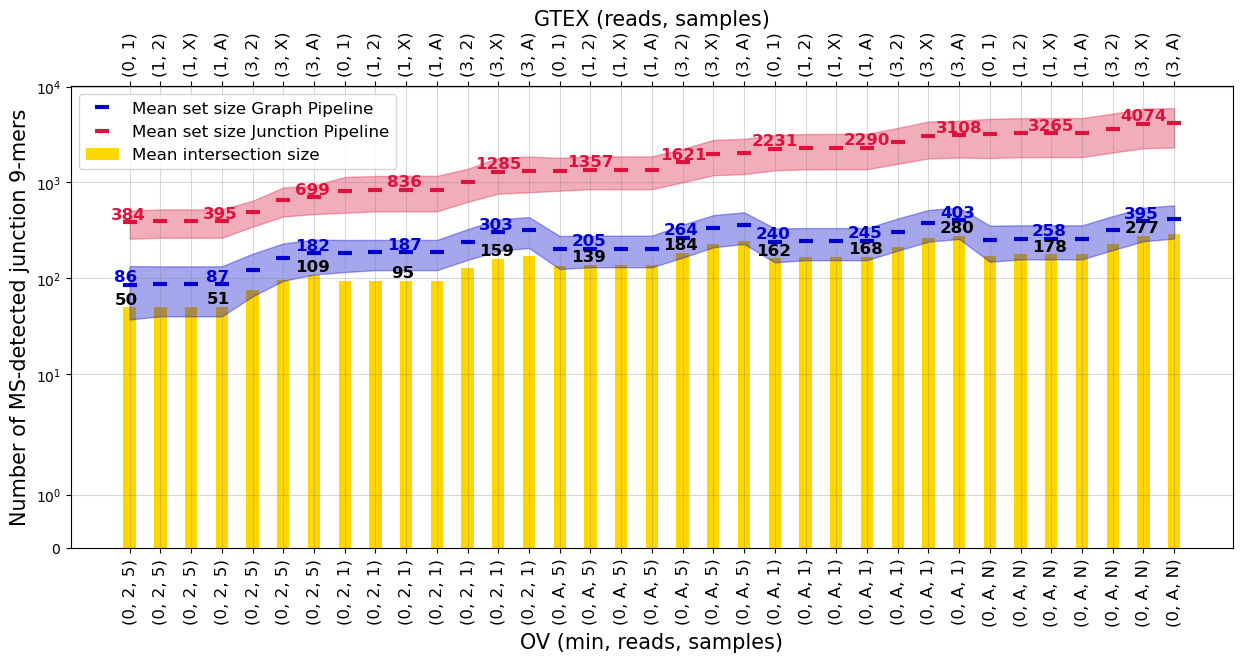

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers_crema_joint.tsv.gz


,sample,filter_,pep_size_ohsu,pep_size_eth,pep_size_intersection,pep_size_ohsu\eth,pep_size_eth\ohsu
0,TCGA-C8-A12P-01A-11R-A115-07,0211AGA,8,0,0,8,0
1,TCGA-C8-A12P-01A-11R-A115-07,0211XGA,8,0,0,8,0
2,TCGA-C8-A12P-01A-11R-A115-07,02532GA,0,0,0,0,0
3,TCGA-C8-A12P-01A-11R-A115-07,0A101GA,8,0,0,8,0
4,TCGA-C8-A12P-01A-11R-A115-07,0A512GA,0,0,0,0,0


saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/MeanSample_barplot_intersect_junction-9-mers_crema_joint.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:247: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


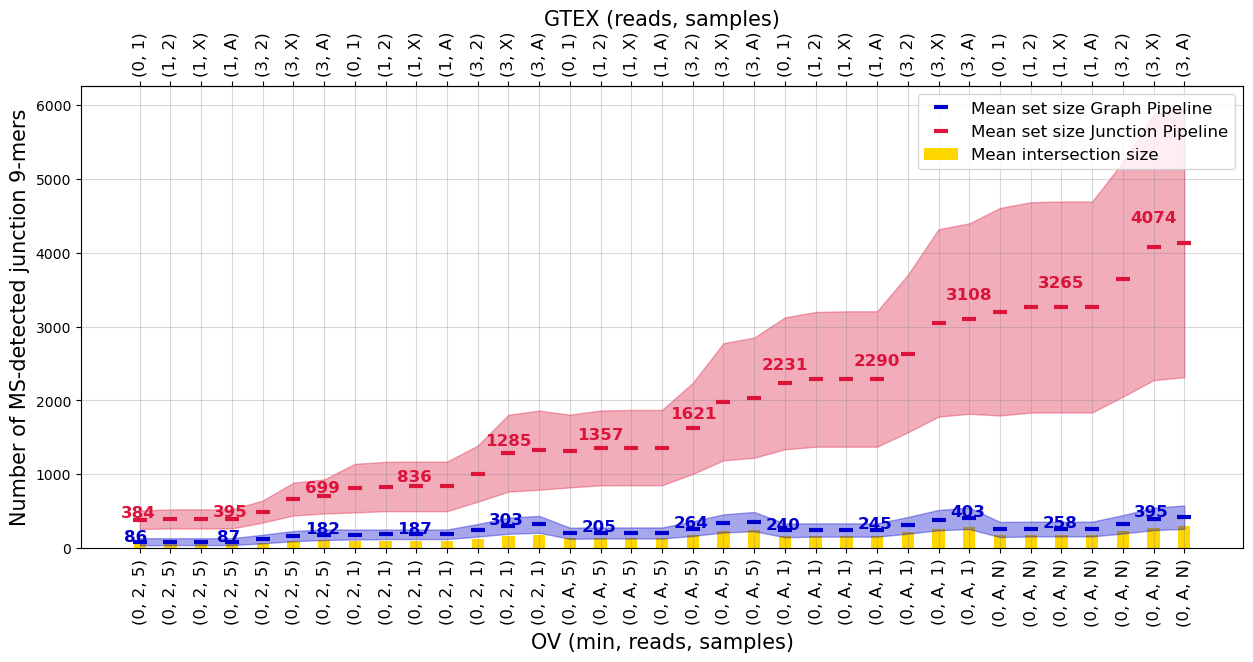

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides_crema_joint.tsv.gz


,sample,filter_,pep_size_ohsu,pep_size_eth,pep_size_intersection,pep_size_ohsu\eth,pep_size_eth\ohsu
0,TCGA-C8-A12P-01A-11R-A115-07,0211AGA,1,0,0,1,0
1,TCGA-C8-A12P-01A-11R-A115-07,0211XGA,1,0,0,1,0
2,TCGA-C8-A12P-01A-11R-A115-07,02532GA,0,0,0,0,0
3,TCGA-C8-A12P-01A-11R-A115-07,0A101GA,1,0,0,1,0
4,TCGA-C8-A12P-01A-11R-A115-07,0A512GA,0,0,0,0,0


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:247: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/MeanSample_barplot_intersect_tryptic-junction-peptides_crema_joint_log.pdf


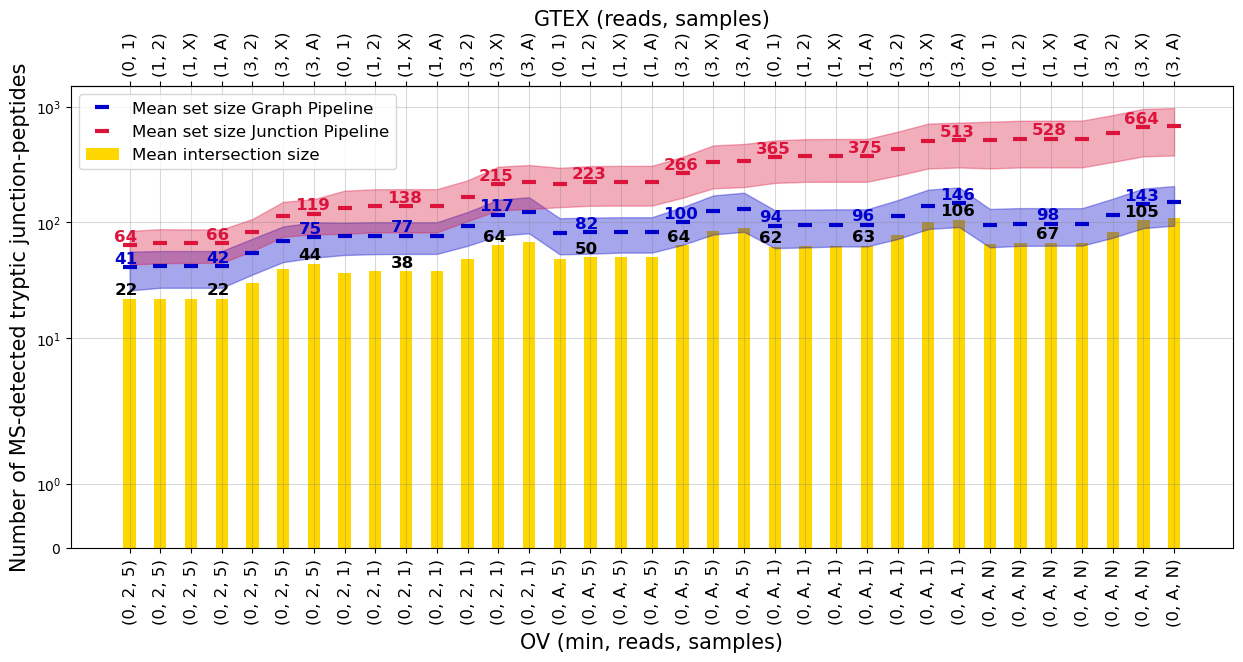

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides_crema_joint.tsv.gz


,sample,filter_,pep_size_ohsu,pep_size_eth,pep_size_intersection,pep_size_ohsu\eth,pep_size_eth\ohsu
0,TCGA-C8-A12P-01A-11R-A115-07,0211AGA,1,0,0,1,0
1,TCGA-C8-A12P-01A-11R-A115-07,0211XGA,1,0,0,1,0
2,TCGA-C8-A12P-01A-11R-A115-07,02532GA,0,0,0,0,0
3,TCGA-C8-A12P-01A-11R-A115-07,0A101GA,1,0,0,1,0
4,TCGA-C8-A12P-01A-11R-A115-07,0A512GA,0,0,0,0,0


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:247: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/MeanSample_barplot_intersect_tryptic-junction-peptides_crema_joint.pdf


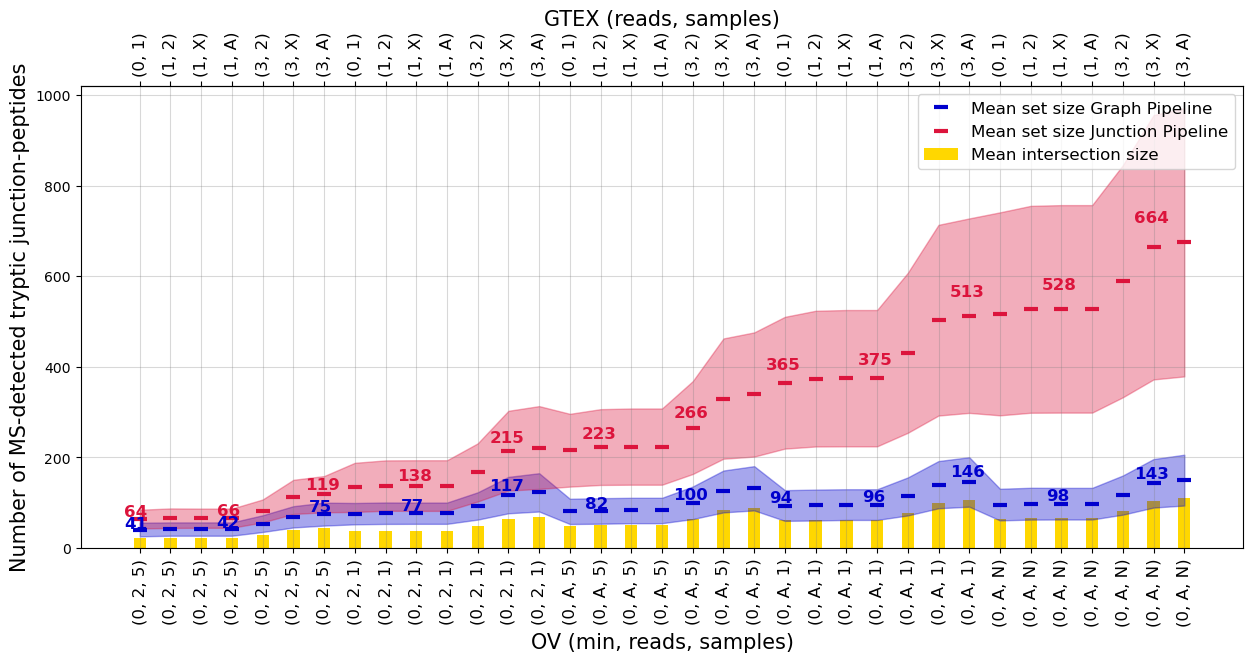

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers-rates_crema_joint.tsv.gz


,sample,filter_,pipeline,validation_rate
0,TCGA-C8-A12P-01A-11R-A115-07,0211AGA,ETH,0.0
1,TCGA-C8-A12P-01A-11R-A115-07,0211AGA,OHSU,5.1
2,TCGA-C8-A12P-01A-11R-A115-07,0211XGA,ETH,0.0
3,TCGA-C8-A12P-01A-11R-A115-07,0211XGA,OHSU,5.1
4,TCGA-C8-A12P-01A-11R-A115-07,02532GA,ETH,0.0


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:247: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/MeanSample_barplot_val-rate_junction-9-mers_crema_joint.pdf


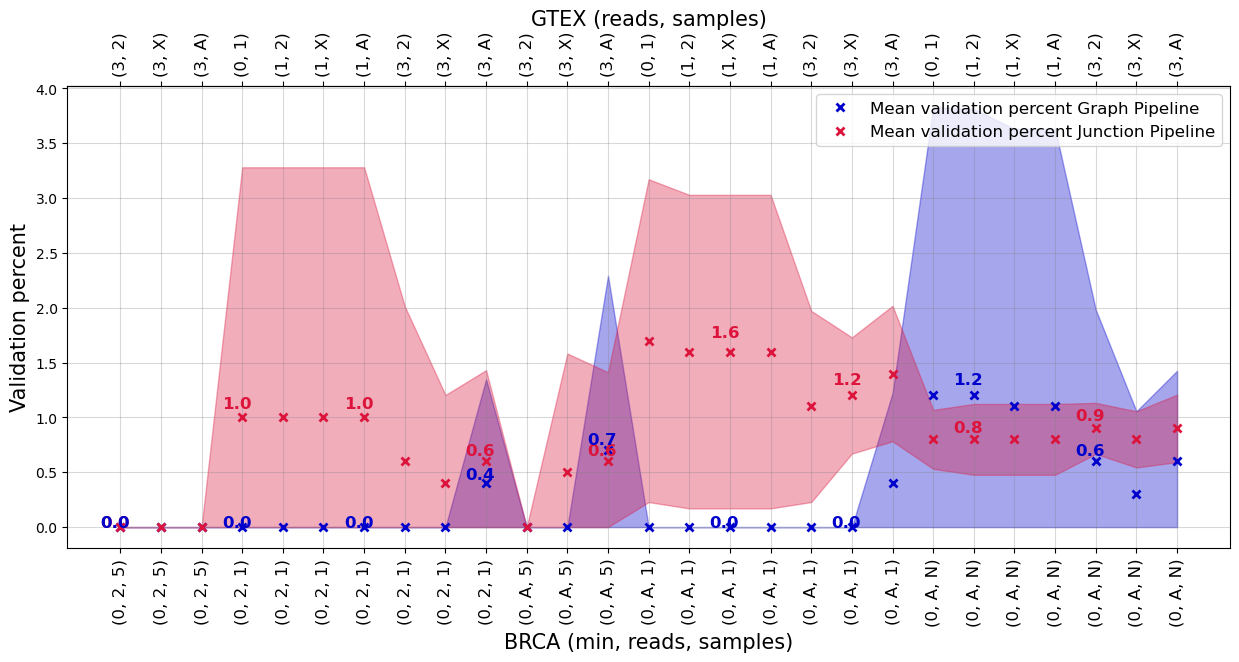

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides-rates_crema_joint.tsv.gz


,sample,filter_,pipeline,validation_rate
0,TCGA-C8-A12P-01A-11R-A115-07,0211AGA,ETH,0.00
1,TCGA-C8-A12P-01A-11R-A115-07,0211AGA,OHSU,5.88
2,TCGA-C8-A12P-01A-11R-A115-07,0211XGA,ETH,0.00
3,TCGA-C8-A12P-01A-11R-A115-07,0211XGA,OHSU,5.88
4,TCGA-C8-A12P-01A-11R-A115-07,02532GA,ETH,0.00


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:247: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/MeanSample_barplot_val-rate_tryptic-junction-peptides_crema_joint.pdf


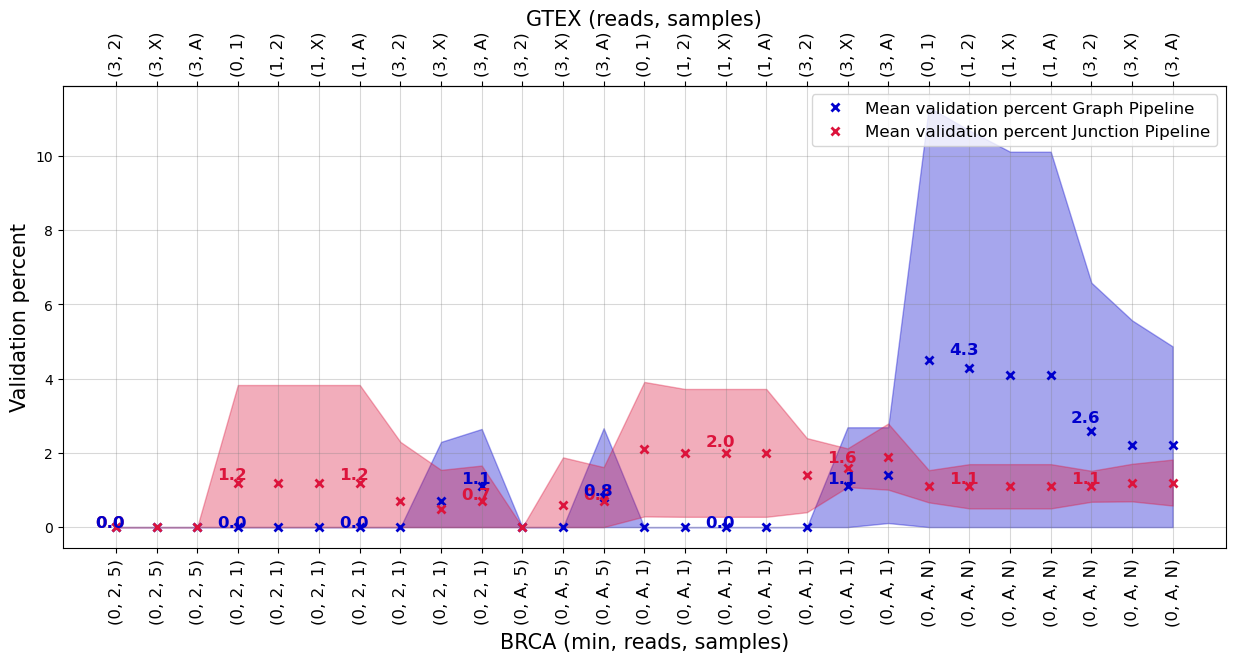

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers_crema_joint.tsv.gz


,sample,filter_,pep_size_ohsu,pep_size_eth,pep_size_intersection,pep_size_ohsu\eth,pep_size_eth\ohsu
0,TCGA-C8-A12P-01A-11R-A115-07,0211AGA,8,0,0,8,0
1,TCGA-C8-A12P-01A-11R-A115-07,0211XGA,8,0,0,8,0
2,TCGA-C8-A12P-01A-11R-A115-07,02532GA,0,0,0,0,0
3,TCGA-C8-A12P-01A-11R-A115-07,0A101GA,8,0,0,8,0
4,TCGA-C8-A12P-01A-11R-A115-07,0A512GA,0,0,0,0,0


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:247: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/MeanSample_barplot_intersect_junction-9-mers_crema_joint_log.pdf


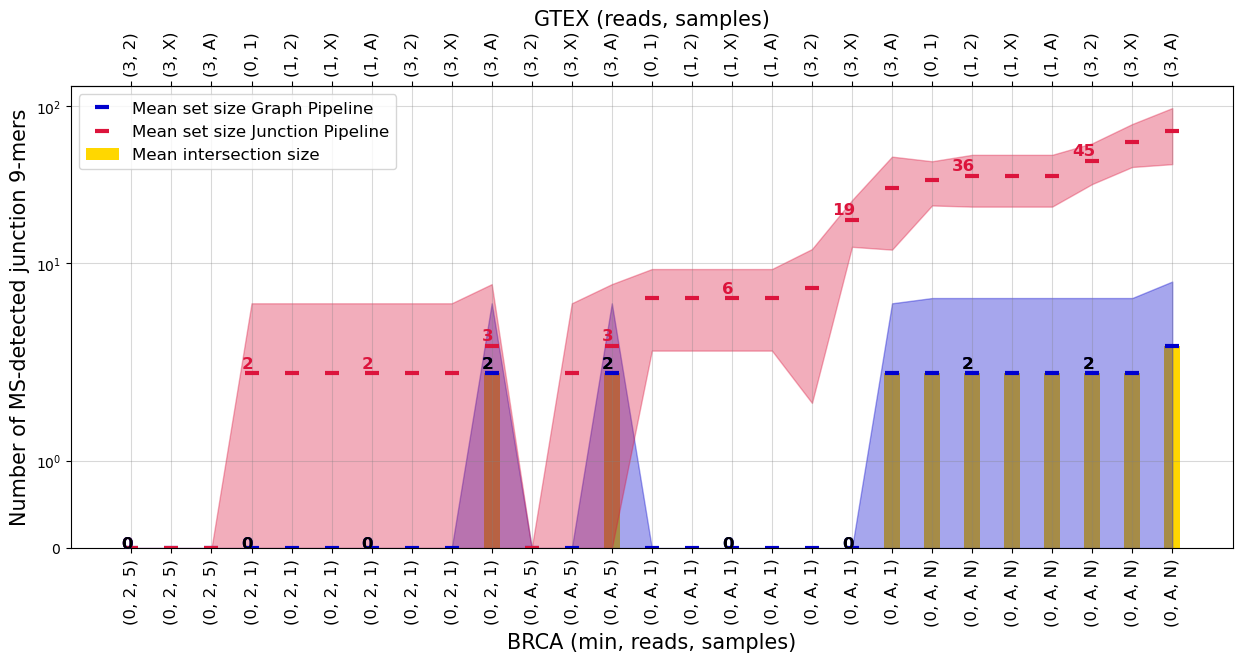

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers_crema_joint.tsv.gz


,sample,filter_,pep_size_ohsu,pep_size_eth,pep_size_intersection,pep_size_ohsu\eth,pep_size_eth\ohsu
0,TCGA-C8-A12P-01A-11R-A115-07,0211AGA,8,0,0,8,0
1,TCGA-C8-A12P-01A-11R-A115-07,0211XGA,8,0,0,8,0
2,TCGA-C8-A12P-01A-11R-A115-07,02532GA,0,0,0,0,0
3,TCGA-C8-A12P-01A-11R-A115-07,0A101GA,8,0,0,8,0
4,TCGA-C8-A12P-01A-11R-A115-07,0A512GA,0,0,0,0,0


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:247: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/MeanSample_barplot_intersect_junction-9-mers_crema_joint.pdf


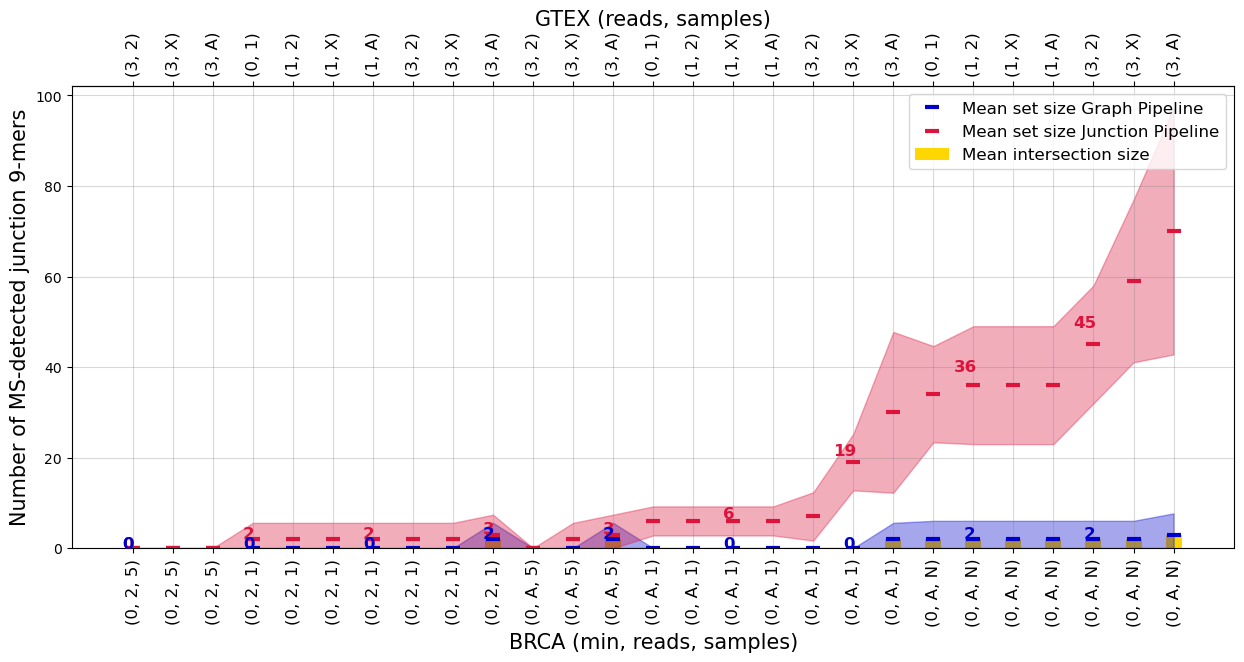

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides_crema_joint.tsv.gz


,sample,filter_,pep_size_ohsu,pep_size_eth,pep_size_intersection,pep_size_ohsu\eth,pep_size_eth\ohsu
0,TCGA-C8-A12P-01A-11R-A115-07,0211AGA,1,0,0,1,0
1,TCGA-C8-A12P-01A-11R-A115-07,0211XGA,1,0,0,1,0
2,TCGA-C8-A12P-01A-11R-A115-07,02532GA,0,0,0,0,0
3,TCGA-C8-A12P-01A-11R-A115-07,0A101GA,1,0,0,1,0
4,TCGA-C8-A12P-01A-11R-A115-07,0A512GA,0,0,0,0,0


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:247: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/MeanSample_barplot_intersect_tryptic-junction-peptides_crema_joint_log.pdf


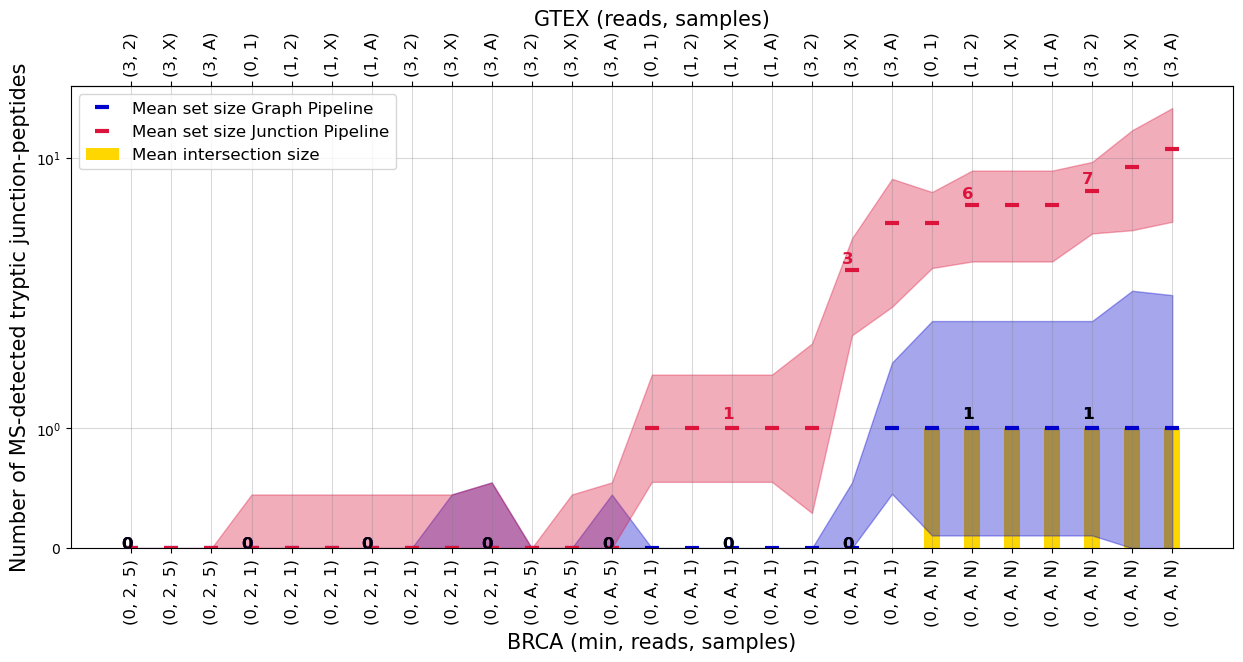

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_peptides_crema_joint.tsv.gz


,sample,filter_,pep_size_ohsu,pep_size_eth,pep_size_intersection,pep_size_ohsu\eth,pep_size_eth\ohsu
0,TCGA-C8-A12P-01A-11R-A115-07,0211AGA,1,0,0,1,0
1,TCGA-C8-A12P-01A-11R-A115-07,0211XGA,1,0,0,1,0
2,TCGA-C8-A12P-01A-11R-A115-07,02532GA,0,0,0,0,0
3,TCGA-C8-A12P-01A-11R-A115-07,0A101GA,1,0,0,1,0
4,TCGA-C8-A12P-01A-11R-A115-07,0A512GA,0,0,0,0,0


saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/MeanSample_barplot_intersect_tryptic-junction-peptides_crema_joint.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:247: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


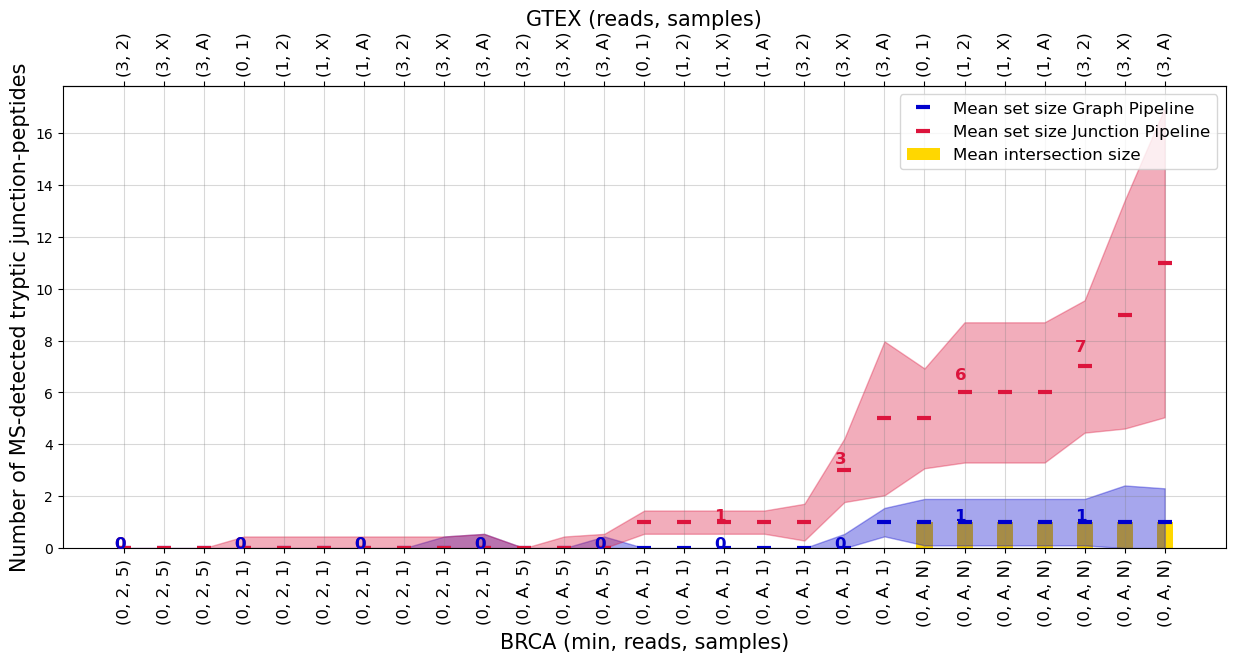

In [7]:
# MAIN 

for MS_FDR in MS_FDR_:
    for MS_strategy in MS_strategy_:
        param_MS.edit_MS( MS_FDR, MS_strategy)
        for sample in ['TCGA-25-1319-01A-01R-1565-13', 'TCGA-AO-A0JM-01A-21R-A056-07']:

            # Intermediate paths filtering
            order_file = os.path.join(sample_plot_dir[sample], f'{sample}_Barplot_sorting.tsv.gz')

            # Intermediate data path MS results
            path_data_pep = os.path.join(save_folder, f'data_peptides{MS_FDR}_{MS_strategy}.tsv.gz')
            path_data_kmers = os.path.join(save_folder, f'data_kmers{MS_FDR}_{MS_strategy}.tsv.gz')
            path_data_peptide_rates = os.path.join(save_folder, f'data_peptides-rates{MS_FDR}_{MS_strategy}.tsv.gz')
            path_data_kmers_rates = os.path.join(save_folder, f'data_kmers-rates{MS_FDR}_{MS_strategy}.tsv.gz')

            # Read data and plot
            group_cols = ['filter_', 'pipeline']
            target_cols = ['validation_rate']
            for suffix, path_data in zip(['junction 9-mers', 'tryptic junction-peptides'], 
                                         [path_data_kmers_rates, path_data_peptide_rates]):
                print(f' Reading {path_data}')
                df = pd.read_csv(path_data, sep = '\t')
                display(df.head())
                df = calculate_mean_std(df, group_cols, target_cols, run_type_plot_dir, sample, decimals=1)
                param_MS.edit_pep_type(suffix)
                param_object.edit_scale(is_log_scale=False)
                param_object.edit_marker(marker_type="x", marker_size=6, markeredgewidth=2)

                df_plot = run_sample_plotting_rates(sample, df, param_MS, param_object)
            
            # Read data and plot
            group_cols = ['filter_']
            target_cols = ['pep_size_ohsu', 'pep_size_eth', 'pep_size_intersection', 
                              'pep_size_ohsu\eth', 'pep_size_eth\ohsu']
            for suffix, path_data in zip(['junction 9-mers', 'tryptic junction-peptides'], 
                                         [path_data_kmers, path_data_pep]):
                for log_option in [True, False]:
                    print(f' Reading {path_data}')
                    df = pd.read_csv(path_data, sep = '\t')
                    display(df.head())
                    df = calculate_mean_std(df, group_cols, target_cols, run_type_plot_dir, sample, decimals=0)
                    param_MS.edit_pep_type(suffix)
                    param_object.edit_scale(is_log_scale=log_option)
                    param_object.edit_marker(marker_type = "_", marker_size = 10, markeredgewidth=3)
                    df_plot = run_sample_plotting_overlap(sample, df, param_MS, param_object)


# DEBUG